In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import time

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
data = pd.read_csv('df_raw.csv', index_col = 0, parse_dates=True)
data.shape[1]

144

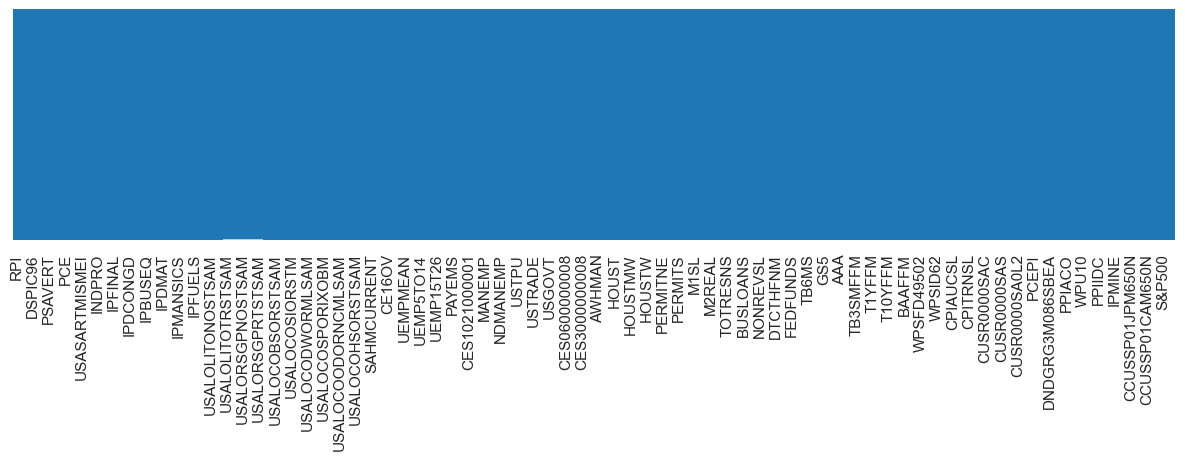

In [3]:
# visualize missing data
def check_missing_data(df):
  plt.figure(figsize=(15,3))
  sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap ='tab20');

check_missing_data(data)

# Feature Engineering
When dealing with time series data, adding lag features can be valuable for capturing temporal patterns and dependencies. By including lagged versions of a variable, machine learning models can potentially learn from historical information and make predictions based on past behavior.

### Add lagged features

In [4]:
def add_lag_features(df, lags=[3,6,9,12,18]):
  '''
  Returns df with the specified lag variables added
  ----------
  Parameters
  ----------
  df : original dataframe
  lags: list of months to include lags
  '''
  for col in df.drop(['Regime'], axis=1):
    for n in lags:
      df['{}_{}M_lag'.format(col, n)] = df[col].shift(n).ffill().values
  df.dropna(axis=0, inplace=True)
  return df

In [5]:
# Add lag features
data = add_lag_features(data)
data

,RPI,W875RX1,DSPIC96,PIROA,PSAVERT,DPCERA3M086SBEA,PCE,W055RC1,USASARTMISMEI,USASLRTCR03MLSAM,...,CCUSSP02CNM650N_3M_lag,CCUSSP02CNM650N_6M_lag,CCUSSP02CNM650N_9M_lag,CCUSSP02CNM650N_12M_lag,CCUSSP02CNM650N_18M_lag,S&P500_3M_lag,S&P500_6M_lag,S&P500_9M_lag,S&P500_12M_lag,S&P500_18M_lag
1961-07-01,2817.586,2620.7,2517.6,47.3,12.0,16.310,340.6,47.1,33.909612,497500.000000,...,2.4618,2.4618,2.4618,2.4618,2.4618,65.31,61.78,53.39,55.51,55.61
1961-08-01,2819.181,2631.9,2517.7,47.6,11.7,16.368,342.1,47.4,34.260473,498083.333333,...,2.4618,2.4618,2.4618,2.4618,2.4618,66.56,63.44,55.54,56.96,56.12
1961-09-01,2822.627,2637.0,2519.9,48.2,11.3,16.460,344.4,47.7,34.274444,501416.666667,...,2.4618,2.4618,2.4618,2.4618,2.4618,64.64,65.06,58.11,53.52,55.34
1961-10-01,2850.442,2665.2,2546.6,48.9,11.7,16.563,346.5,47.9,34.891783,521000.000000,...,2.4618,2.4618,2.4618,2.4618,2.4618,66.76,65.31,61.78,53.39,54.37
1961-11-01,2875.937,2689.7,2570.1,49.3,11.6,16.724,349.9,48.2,35.137973,547166.666667,...,2.4618,2.4618,2.4618,2.4618,2.4618,68.07,66.56,63.44,55.54,55.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-01,19022.031,15592.2,16763.9,3606.8,5.2,115.246,18363.8,2707.4,118.406649,267833.333333,...,6.7529,7.2929,6.7286,6.5866,6.3904,4076.60,3871.98,4130.29,4131.93,4605.38
2023-05-01,19060.676,15622.4,16818.5,3610.2,5.3,115.400,18407.8,2691.2,118.883843,263666.666667,...,6.9449,7.1418,6.8934,6.6612,6.3716,3970.15,4080.11,3955.00,4132.15,4567.00
2023-06-01,19066.014,15638.0,16809.5,3590.7,4.8,115.693,18485.4,2712.9,118.823705,261250.000000,...,6.8685,6.9860,7.0958,6.6948,6.3704,4109.31,3839.50,3585.62,3785.38,4766.18
2023-07-01,19084.305,15680.1,16808.4,3594.4,4.4,116.235,18595.4,2739.7,119.229222,267833.333333,...,6.9232,6.7529,7.2929,6.7286,6.3642,4169.48,4076.60,3871.98,4130.29,4515.55


# Data Processing

### Stationarity & Differentiation
Prior to applying a predictive model, it is essential to make the time series data stationary. The initial step involves conducting the Augmented Dickey-Fuller (ADF) test. Following the ADF test, the next step is to achieve stationarity by differentiating variables that do not pass the ADF test.

The ADF test helps us assess whether our time series data is stationary or not. If the data is not stationary, additional steps such as differencing or other transformations may be required to achieve stationarity before applying time series models.

https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/


In [6]:
# # How to use ADF test
# df = data.copy()
# cols = df.drop(['Regime'], axis=1).columns
# result = adfuller(df[cols[0]])
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])

In [7]:
# # 1st-order differencing
# df = data.copy()
# threshold = 0.01
# nonstationary_cols = []
# for col in df.drop(['Regime'], axis=1).columns:
#   result = adfuller(df[col])
#   if result[1] > threshold:
#     nonstationary_cols.append(col)
#     df[col] = df[col].diff()
# df.dropna(axis=0, inplace=True)
# print(df.shape)
# print(f'Nubmer of Non-stationary columns: {len(nonstationary_cols)}')
# df.head()

In [8]:
# # 2nd-order differencing
# threshold = 0.01
# nonstationary_cols = []
# for col in df.drop(['Regime'], axis=1).columns:
#   result = adfuller(df[col])
#   if result[1] > threshold:
#     nonstationary_cols.append(col)
#     df[col] = df[col].diff()
# df.dropna(axis=0, inplace=True)
# print(df.shape)
# print(len(nonstationary_cols))
# df.head()

In [9]:
# # 3rd-order differencing
# threshold = 0.01
# nonstationary_cols = []
# for col in df.drop(['Regime'], axis=1).columns:
#   result = adfuller(df[col])
#   if result[1] > threshold:
#     nonstationary_cols.append(col)
#     df[col] = df[col].diff()
# df.dropna(axis=0, inplace=True)
# print(df.shape)
# print(len(nonstationary_cols))
# print(nonstationary_cols)
# df.head()

Combine all above processes into one function...

In [10]:
def stationarize_data(df, threshold=0.01, max_non_stationary_cols=10):
  '''
  Iteratively difference the time series until the number of non-stationary columns is less than a specified threshold.

  Parameters:
  - df (pd.DataFrame): Input dataframe containing time series data.
  - threshold (float): ADF test p-value threshold for considering a column as non-stationary.
  - max_non_stationary_cols (int): Maximum number of non-stationary columns allowed.

  Returns:
  - df (pd.DataFrame): Dataframe after differencing.
  - non_stationary_cols (list): List of non-stationary columns.
  '''

  # Initial set of non-stationary columns
  non_stationary_cols = df.drop(['Regime'], axis=1).columns
  iteration_count = 0

  # Iterate until the number of non-stationary columns is less than the specified threshold
  while len(non_stationary_cols) >= max_non_stationary_cols:
    iteration_count += 1
    print(f'\nIteration {iteration_count}:')

    # Columns to be differenced in this iteration
    need_diff = []

    # Check ADF test p-value for each column
    for col in df.drop(['Regime'], axis=1).columns:
      result = adfuller(df[col])
      if result[1] > threshold:
        need_diff.append(col)
        df[col] = df[col].diff()

    # Update the set of non-stationary columns for the next iteration
    non_stationary_cols = need_diff

    # Drop NaN rows after differencing
    df.dropna(axis=0, inplace=True)
    print(f'Number of Non-stationary columns: {len(non_stationary_cols)}')

  print(f'\nDataframe shape after differencing: {df.shape}')
  return df, non_stationary_cols

In [11]:
df, non_stationary_cols = stationarize_data(data, threshold=0.01)

print(f'\ncolumns to delete: {non_stationary_cols}')


Iteration 1:
Number of Non-stationary columns: 649

Iteration 2:
Number of Non-stationary columns: 81

Iteration 3:
Number of Non-stationary columns: 3

Dataframe shape after differencing: (743, 859)

columns to delete: ['USALOCOHSORSTSAM', 'AWHMAN', 'IPNCONGD_18M_lag']


In [12]:
# Drop non-statinary columns
df.drop(non_stationary_cols, axis=1, inplace=True)
df.shape

(743, 856)

In [13]:
df.to_csv('df_processed.csv')